In [1]:
import pandas as pd
import numpy as np
from googletrans import Translator
from tqdm import tqdm
import seaborn as sns

df = pd.read_csv('preprocessed_data.csv').drop('Unnamed: 0', axis = 1)

<Axes: xlabel='label', ylabel='Count'>

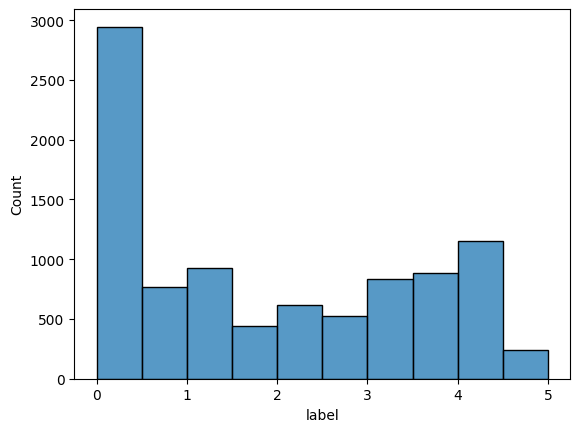

In [2]:
sns.histplot(df['label'], bins = 10)

## 데이터의 label 수가 일정하지 않음.
## sentence_1, sentence_2의 순서를 바꾸는 증강을 통해 label 수의 분포를 대강적으로 맞추도록 조정.

In [3]:
def swap_sentence(df, target = 300):
    aug_data = pd.DataFrame({'id' : [], 'source' : [], 'sentence_1' : [], 'sentence_2' : [],
                             'label' : [], 'binary-label' : []})
    for i in np.arange(0.0,5.2,0.2):
        target_df = df[df['label'] == round(i,2)]
        cnt = len(target_df)
        if target - cnt < 0:
            pass
        else:
            samples = target_df.sample(min(cnt, target - cnt))
            aug = pd.DataFrame({'id' : samples['id'], 'source' : samples['source'],
                                'sentence_1' : samples['sentence_2'], 
                                'sentence_2' : samples['sentence_1'],
                                'label' : samples['label'], 'binary-label' : samples['binary-label']})
            aug_data = pd.concat([aug_data, aug])
    return aug_data

In [4]:
aug_data = pd.concat([df, swap_sentence(df, target = 300)])
for i in np.arange(0.0,5.2,0.2):
    print(f'label {round(i,2)} : {len(df[df["label"] == round(i,2)])}개 > {len(aug_data[aug_data["label"] == round(i,2)])}개')

label 0.0 : 2119개 > 2119개
label 0.2 : 345개 > 345개
label 0.4 : 482개 > 482개
label 0.6 : 372개 > 372개
label 0.8 : 358개 > 358개
label 1.0 : 342개 > 342개
label 1.2 : 332개 > 332개
label 1.4 : 254개 > 300개
label 1.6 : 172개 > 300개
label 1.8 : 246개 > 300개
label 2.0 : 236개 > 300개
label 2.2 : 190개 > 300개
label 2.4 : 187개 > 300개
label 2.6 : 235개 > 300개
label 2.8 : 267개 > 300개
label 3.0 : 283개 > 300개
label 3.2 : 270개 > 300개
label 3.4 : 279개 > 300개
label 3.6 : 400개 > 400개
label 3.8 : 452개 > 452개
label 4.0 : 516개 > 516개
label 4.2 : 426개 > 426개
label 4.4 : 209개 > 300개
label 4.6 : 81개 > 162개
label 4.8 : 59개 > 118개
label 5.0 : 91개 > 182개


## sentence_1과 sentence_2의 순서를 바꿔 데이터를 대강적으로 증강.
## label의 수가 많다면 sentence_1과 sentence_2를 바꾸지 않고, label의 수가 적다면 문장을 바꿔 증강하였음.

In [14]:
def back_translate(text, src_lang='ko', intermediate_lang='en'):
    translator = Translator()
    # 원본 텍스트를 intermediate_lang으로 번역
    translated_text = translator.translate(text, src=src_lang, dest=intermediate_lang).text
    # intermediate_lang에서 원본 src_lang으로 번역
    back_translated_text = translator.translate(translated_text, src=intermediate_lang, dest=src_lang).text
    return back_translated_text

In [16]:
intermediate_lang = 'ja'
sentence = aug_data.sample(1)['sentence_1'].item()
print('원본 문장 : ',sentence)
sentence = back_translate(sentence, intermediate_lang = intermediate_lang)
print('역번역 문장 : ',sentence)


원본 문장 :  다음 주에 진행할 마스터 클래스 안내하며 나갈 정보입니다.
역번역 문장 :  이것은 다음 주 마스터 클래스에서 도출 한 정보입니다.


## 구글 번역 라이브러리를 통해 start 언어에서 target 언어로, target 언어에서 다시 start 언어로 번역한다.
## 이러한 과정을 통해 원본 문장과 의미는 같지만 다르게 표현된 문장을 얻을 수 있다.


In [7]:
import os
import sys
current_dir = os.getcwd()
k_tacc_path = os.path.join(current_dir, 'K-TACC-main')
sys.path.append(k_tacc_path)

from BERT_augmentation import BERT_Augmentation
from adverb_augmentation import AdverbAugmentation

import transformers


BERT_aug = BERT_Augmentation()
random_masking_insertion = BERT_aug.random_masking_insertion
adverb_aug = AdverbAugmentation()
adverb_gloss_replacement = adverb_aug.adverb_gloss_replacement
ratio = 0

In [26]:

sentence = aug_data.sample(1)['sentence_1'].item()
print('원본 문장 : ', sentence)
print('--random insertion--')
for i in np.arange(0,1,0.2):
    print('증강 문장 :', random_masking_insertion(sentence, ratio = i),'ratio = ', round(i,2))
print('--Adverb insertion--')
print('증강 문장 :', adverb_gloss_replacement(sentence))

원본 문장 :  다시 했으면 좋겠어요.
--random insertion--
증강 문장 : 다시 했으면 좋겠어요. ratio =  0.0
증강 문장 : 다시 다시 했으면 좋겠어요. ratio =  0.2
증강 문장 : 이제 다시 했으면 좋겠어요. ratio =  0.4
증강 문장 : 다시 했으면 그게 참 좋겠어요. ratio =  0.6
증강 문장 : 다시 다시 했으면 참 좋겠어요. ratio =  0.8
--Adverb insertion--
증강 문장 : 이전 상태나 행동이 그쳤다가 이어지면서 새로이 또 했으면 좋겠어요.


## K-TACC-main의 라이브러리를 활용한 BERT 기반 증강 모델을 활용하였다.
## 특히, 성능 평가 중 성능이 가장 높았던 Random Insertion과 Adverb replacement를 채용하였다.
## Random Insertion은 ratio를 통해 그 정도를 조절할 수 있으며, ratio가 높아질 수록 문맥에 맞는 더 많은 단어가 추가됨을 알 수 있다.

#### 자세한 정보는  https://github.com/kyle-bong/K-TACC/tree/main 에서 확인할 수 있습니다.